# Setup Cells

In [2]:
from sage.schemes.elliptic_curves.all import *

In [3]:
R.<u,v,w,s,t> = QQ[]
S.<a,b> = QQ[]
hom_R_S = R.hom([0,0,0,a,b], S)

In [4]:
P = 10*u^3+v^3+3/10*w^3+v^2*w-w^2*v+u*v*w
Q = u^2*v+v^3+5*w^3 + v^2 * w-1/10*u*v*w

In [5]:
pol = Jacobian(s*P+t*Q,variables=[u,v,w]).j_invariant()

In [6]:
# Sage code: stereographic projection of divisor on P^1 to the unit sphere
from sage.all import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # registers 3D projection

def stereographic_map(z):
    """
    Stereographically project complex number z (affine coordinate) to unit sphere (x,y,z3).
    North pole (0,0,1) corresponds to z = infinity.
    """
    x0 = float(z.real)
    y0 = float(z.imag)
    r2 = x0*x0 + y0*y0
    denom = 1.0 + r2
    x = 2.0 * x0 / denom
    y = 2.0 * y0 / denom
    z3 = (r2 - 1.0) / denom
    return (x, y, z3)

def plot_divisor_on_sphere_extra(f, tol=1e-8, sphere_res=60, figsize=(8,8), show_mult_labels=True,frame=False):
    """
    f : homogeneous polynomial in R.<s,t> (Sage polynomial)
    tol: tolerance for numeric clustering (used in fallback numeric rootfinding)
    """
    # basic checks
    R = f.parent()
    gens = R.gens()
    if len(gens) < 2:
        raise ValueError("Input polynomial must be in two variables s,t.")
    s, t = gens[0], gens[1]
    d = f.total_degree()
    if d <= 0:
        raise ValueError("Polynomial must have positive degree.")
    # collect homogeneous coefficients a_i for s^i t^(d-i)
    const_ring = R.base_ring()
    a = [ const_ring(f.coefficient(s**i * t**(d-i))) for i in range(d+1) ]  # a[0]..a[d]
    #print(a)

    base = f.base_ring()
    z = polynomial_ring = PolynomialRing(base, 'z').gen()
    h = sum( a[i]*z**i for i in range(d+1) )
    finite_roots = []   # list of (complex_value, multiplicity)

    if not finite_roots:
        try:
            h_cc = h.change_ring(CC)
            # h_cc.roots() returns list of (root, multiplicity) in CC in recent Sage versions
            roots_cc = h_cc.roots(multiplicities=True)
            if roots_cc:
                for root, mult in roots_cc:
                    finite_roots.append((complex(root), int(mult)))
            else:
                # As another fallback use numpy.roots on coefficient list
                coeffs = [ complex(ai) for ai in a[::-1] ]  # numpy expects highest-first
                roots_np = np.roots(coeffs)
                # cluster nearby roots into multiplicities
                used = np.zeros(len(roots_np), dtype=bool)
                for i,r in enumerate(roots_np):
                    if used[i]:
                        continue
                    mult = 1
                    used[i] = True
                    for j in range(i+1, len(roots_np)):
                        if not used[j] and abs(roots_np[j]-r) < tol:
                            mult += 1
                            used[j] = True
                    finite_roots.append((complex(r), int(mult)))
        except Exception:
            # ultimate fallback: numpy.roots directly
            coeffs = [ complex(ai) for ai in a[::-1] ]  # highest-first for numpy
            roots_np = np.roots(coeffs)
            used = np.zeros(len(roots_np), dtype=bool)
            for i,r in enumerate(roots_np):
                if used[i]:
                    continue
                mult = 1
                used[i] = True
                for j in range(i+1, len(roots_np)):
                    if not used[j] and abs(roots_np[j]-r) < tol:
                        mult += 1
                        used[j] = True
                finite_roots.append((complex(r), int(mult)))

    # compute multiplicity at infinity:

    m_inf = 0
    for i in range(d, -1, -1):
        ai = a[i]
        # treat both symbolic zero and numerically small as zero
        if ai == 0 or (isinstance(ai, (int, float, complex)) and abs(complex(ai)) < 1e-12):
            m_inf += 1
        else:
            break

    S = sphere((0,0,0), 1, color='lightblue', opacity=0.28,frame=frame)  # translucent sphere
    G = S
    stereos = []

    for (rc, mult) in finite_roots:
        if not (np.isfinite(rc.real) and np.isfinite(rc.imag)):
            continue
        x,y,z3 = stereographic_map(rc)
        # size scaled by multiplicity
        size = 3 + 3*mult
        # choose color by multiplicity (simple palette)
        color = 'red' if mult==1 else 'orange' if mult==2 else 'magenta'
        stereos.append([x,y,z3])
        G += point3d((x,y,z3), size=size, color=color)
        # label multiplicity (or exact root if requested and available)
        label = None
        if mult > 1:
            label = str(mult)
        if label:
            # place the text slightly above the point
            G += text3d(label, (x, y, z3 + 0.03), color='black', fontsize=10)

    # Add infinity if present
    if m_inf > 0:
        stereos.append([0.0,0.0,1.0])
        G += point3d((0.0, 0.0, 1.0), size=3 + 3*m_inf, color='green')
        if m_inf > 1:
            G += text3d(str(m_inf), (0.0, 0.0, 1.03), color='black', fontsize=10)

    return (G,stereos)

def plot_divisor_on_sphere(f, tol=1e-8, sphere_res=60, figsize=(8,8), show_mult_labels=True,frame=False):
    G,_ = plot_divisor_on_sphere_extra(f, tol, sphere_res, figsize, show_mult_labels,frame)
    return G


def build_sage_polynomial_from_coeffs(coeffs_complex, degree):
    CC53 = ComplexField(53)
    R = PolynomialRing(CC53, 2, names=('s','t'))
    s, t = R.gens()

    a_cc = [ CC53(c) for c in coeffs_complex ]
    f = sum(a_cc[i] * s**i * t**(degree - i) for i in range(degree+1))
    return f

In [7]:
def random_cubic(coeff_range=6,R=None,C=ComplexField(53)):
    if R == None:
        R.<u,v,w> = C[]
    mons = R.monomials_of_degree(3)
    def make_coeff():
        x = float(np.random.uniform(-coeff_range,coeff_range))
        y = float(np.random.uniform(-coeff_range,coeff_range))
        return x+y * C.gen()
    terms = [make_coeff() * m for m in mons]
    return sum(terms)

def random_cubic_pencil(coeff_range=6):
    CC53 = ComplexField(53)
    R.<u,v,w> = CC53[]
    S.<x,y,z,s,t> = CC53[]
    P = random_cubic()
    Q = random_cubic()
    hom_it = R.hom([x,y,z],S)
    return ([x,y,z], [s,t], P,Q, Jacobian(s*hom_it(P)+t*hom_it(Q),variables=[x,y,z]))

def pencil_to_j(pencil):
    XYZ, ST, _,_, jacs = pencil
    J = jacs.j_invariant()
    R.<s,t> = J.parent().base_ring()[]
    hom_her = J.parent().hom([0,0,0,s,t],R)
    return hom_her(J.numerator())/hom_her(J.denominator())

In [8]:
def degen_normal_pencils(P,Q,TP,TQ,N=100, R=None):
    if R == None:
        R = P.parent()
    assert len(R.gens()) == 3
    S.<x,y,z,s,t> = CC53[]
    hom_it = R.hom([x,y,z],S)

    jac_base = Jacobian(s*hom_it(P) + t*hom_it(Q),variables = [x,y,z])
    pencil_base = ([x,y,z], [s,t], P, Q, jac_base)
    G_base, stereo_base = plot_divisor_on_sphere_extra(pencil_to_j(pencil_base).denominator())

    result = {}
    result["base"] = (pencil_base, G_base, stereo_base)
    result["list"] = [] 
    for j in range(0,N):
        P_new = P + e**(2*pi*I*(j/N))*TP
        Q_new = Q + e**(2*pi*I*(j/N))*TQ
        jac = Jacobian(s*hom_it(P_new) + t*hom_it(Q_new),variables = [x,y,z])
        pencil = ([x,y,z], [s,t], P_new, Q_new, jac)
        G, stereo = plot_divisor_on_sphere_extra(pencil_to_j(pencil).denominator())
        result["list"].append((pencil,G, stereo))
    return (result["base"], result["list"])

def animate_degen(lst,iterations=None):
    return animate([l[1] for l in lst],iterations=iterations)

def export_degen(lst, file_name):
    stereos = [l[2] for l in lst]
    with open(file_name,'w') as myfile:
        wr = csv.writer(myfile)
        for lsst in stereos:
            wr.writerow(lsst)

# Animation Playground

Animation with 100 frames
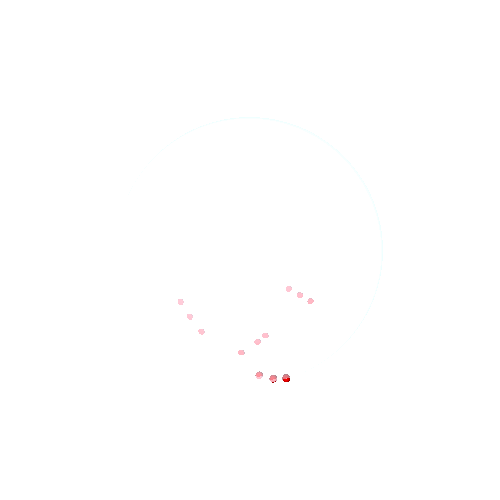

In [9]:
CC53 = ComplexField(53)
R.<u,v,w> = CC53[]
S.<x,y,z,s,t> = CC53[]
hom_it = R.hom([x,y,z], S)

fermat = u**3 + v ** 3 + w ** 3
three_lines = u*v*w
push_off = 0.1*v**3 + 0.05*(u-w)**3
fermat_lines, fermat_lines_lst = degen_normal_pencils(fermat,three_lines, 0, push_off) 
animate_degen(fermat_lines_lst)

In [55]:
def k_mat(k):
    return matrix([[k+1,-1],[k**2,-k+1]])

import math
math.prod([k_mat(k) for k in [0,1,2,3,4,5]])

[ 1  0]
[-6  1]

In [56]:
k_mat(1)

[ 2 -1]
[ 1  0]

Animation with 20 frames
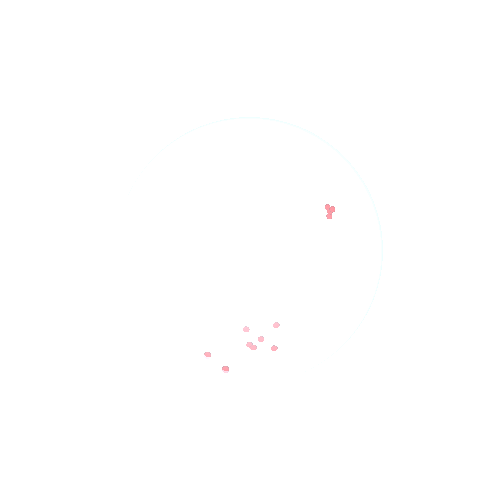

In [42]:
CC53 = ComplexField(53)
R.<u,v,w> = CC53[]
triple_fermat, triple_fermat_lst = degen_normal_pencils(1*fermat,u**3, 0,0.2*v*(u-w)**2+0.15*u*(v-w)**2,N=20)
animate_degen(triple_fermat_lst)

Animation with 60 frames
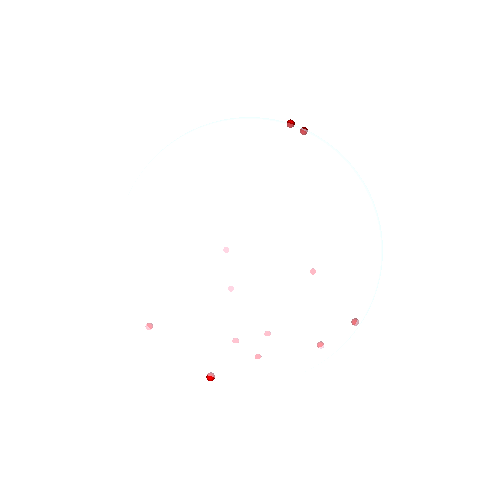

In [15]:
CC53 = ComplexField(53)
R.<u,v,w> = CC53[]
cusp_fermat, cusp_fermat_lst = degen_normal_pencils(fermat,(u+0.3*v+w)**3 - v**2 * w, 0,0.05*w**3,N=60)
animate_degen(cusp_fermat_lst).show(iterations=0)

Animation with 20 frames
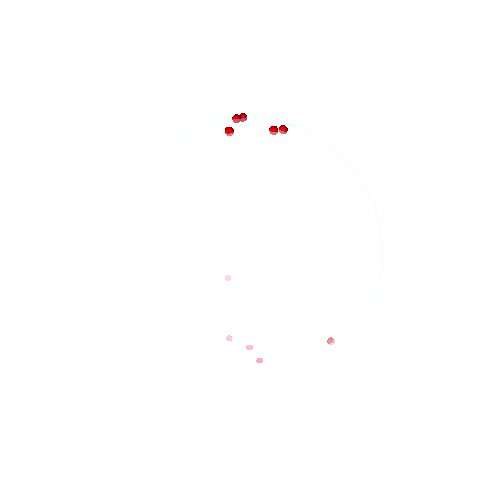

In [41]:
CC53 = ComplexField(53)
R.<u,v,w> = CC53[]
line_21_fermat, line_21_fermat_lst = degen_normal_pencils(1/10*((u+v+0.05*w)**3+w**3+v**3),u**2*w, 0,0.03*(u-v+w)**3,N=20)
animate_degen(line_21_fermat_lst)

# Resultants

In [47]:
S.<s,t,p,x,y,z> = QQ[]
P = x**3 + y**3 + z**3
Q = p*z**3 + y**2*z - x**3 - x*z**2
jj = Jacobian(s*P+t*Q,variables=[x,y,z]).j_invariant()
R.<u,v,w,q> = QQ[]
L.<a,b> = R[]
hom = S.hom([a,b,q,u,v,w], L)
print(jj.parent())
L.macaulay_resultant(hom(jj.denominator().derivative(s)),hom(jj.denominator().derivative(t)))

Fraction Field of Multivariate Polynomial Ring in s, t, p, x, y, z over Rational Field


-133692710994651819302594331120929391200531731425521544312861071769600000000*q^20 - 881381576186963845772658923686127097544246229397882773618121139814400000000*q^19 - 2558500701078720893128248989668156291685347304687861542810322101862400000000*q^18 - 4995460104055612814321293845765316773476760005802676166251933335552000000000*q^17 - 8436609772956476351744796873610554459181161239826742474284803398041600000000*q^16 - 13018931519304730640106200183143305989737135323448156699724508404121600000000*q^15 - 17518472017469381188693648886288539078116593002204258200098412743884800000000*q^14 - 19983624692999832127667852294940222070775569746598796191893997328793600000000*q^13 - 20386898190246911797449022939646886593003777608178429669228577344716800000000*q^12 - 19446771102659784185389423116304724996050394183037677589111499023974400000000*q^11 - 17408729827461958726589361287371177878315624097565186272173296399155200000000*q^10 - 13731961007020238316538814734021816281703307755645859641795964986982400

In [63]:
%%capture
nice_pencil = random_cubic_pencil()
good_pencil = nice_pencil
good_pencil

In [19]:
%%capture
XYZ, ST, P1, P2, _ = good_pencil 
lst = []
CC53 = ComplexField(53)
R = P1.parent()
S.<x,y,z,s,t> = CC53[]
hom_it = R.hom([x,y,z], S)
N = 10
u = R.gens()[0]
N = 200
stereo_lst = []

for j in range(0,N):
    P1_new = e^(2*pi*I*(j/N)) * P1
    pencil = ([x,y,z], [s,t], P1_new, P2, Jacobian(s*hom_it(P1_new) + t*hom_it(P2),variables = [x,y,z]))
    G, stereo = plot_divisor_on_sphere_extra(pencil_to_j(pencil).denominator())
    lst.append(G)
    stereo_lst.append(stereo)